In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
from salishsea_tools import Keegan_eval_tools as ket
import json
from collections import OrderedDict
from matplotlib.colors import LogNorm
import arrow
import glob
import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib.dates import HourLocator, MonthLocator, YearLocator

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [3]:
yearList = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

data = 'month-avg.202111'
#year = '2014'
month = '01'
file = 'grid'

for year in yearList:
    files=[glob.glob(f'/results2/SalishSea/{data}/SalishSeaCast_1m_{file}_T_*{year}*{month:02d}01_*{year}*{month:02d}??.nc')[0] for year in yearList for month in range(1,13) ]
    

## Bring in grid coordinates for Juan de Fuca slice/box

In [4]:
ii, ij = 300,365
ji, jj = 50, 100


In [5]:
JdF = [300,365, 50, 100]

In [6]:
## Gathering metadata but still not opening the files
JdFfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','vosaline','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [7]:
np.shape(JdF)

(4,)

In [8]:
np.shape(JdFfiles.time)

(192,)

In [9]:
np.shape(tmask) 

(40, 898, 398)

In [10]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [11]:
JdFmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(192,40,65,50))

In [12]:
np.shape(JdFmask) 

(192, 40, 65, 50)

In [13]:
tt=np.array(JdFfiles.time)
JdF_depth=np.array(JdFfiles.depth)
JdF_votemper=(JdFfiles.votemper[:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
JdF_votemper = (np.array(JdF_votemper))

JdF_votemper = np.ma.masked_where(JdFmask==0,JdF_votemper) ## masking where there is land

In [14]:
JdF_votemper = JdF_votemper.T ## transpose the variable to make it work with the Hovmoller plots

In [15]:
np.shape(JdF_votemper)

(50, 65, 40, 192)

## Bring in grid coordinates for Haro Strait slice/box

In [16]:
Haro = [280,320, 210, 250]

In [17]:
## Gathering metadata but still not opening the files
Harofiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','vosaline','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [18]:
np.shape(Haro)

(4,)

In [19]:
np.shape(Harofiles.time)

(192,)

In [20]:
np.shape(tmask) 

(40, 898, 398)

In [21]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [22]:
Haromask=np.broadcast_to(tmask[:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]],(192,40,40,40))

In [23]:
np.shape(Haromask) 

(192, 40, 40, 40)

In [24]:
tt=np.array(Harofiles.time)
Haro_depth=np.array(Harofiles.depth)
Haro_votemper=(Harofiles.votemper[:,:, Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]])
Haro_votemper = (np.array(Haro_votemper))

Haro_votemper = np.ma.masked_where(Haromask==0,Haro_votemper) ## masking where there is land

In [25]:
Haro_votemper = Haro_votemper.T ## transpose the variable to make it work with the Hovmoller plots

In [26]:
np.shape(Haro_votemper)

(40, 40, 40, 192)

## Bring in grid coordinates for Puget Sound slice/box

In [27]:
Puget = [75,125, 225, 280]

In [28]:
## Gathering metadata but still not opening the files
Pugetfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','vosaline','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [29]:
np.shape(Puget)

(4,)

In [30]:
np.shape(Pugetfiles.time)

(192,)

In [31]:
np.shape(tmask) 

(40, 898, 398)

In [32]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [33]:
Pugetmask=np.broadcast_to(tmask[:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]],(192,40,50,55))

In [34]:
np.shape(Pugetmask) 

(192, 40, 50, 55)

In [35]:
tt=np.array(Pugetfiles.time)
Puget_depth=np.array(Pugetfiles.depth)
Puget_votemper=(Pugetfiles.votemper[:,:, Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]])
Puget_votemper = (np.array(Puget_votemper))

Puget_votemper = np.ma.masked_where(Pugetmask==0,Puget_votemper) ## masking where there is land

In [36]:
Puget_votemper = Puget_votemper.T ## transpose the variable to make it work with the Hovmoller plots

In [37]:
np.shape(Puget_votemper)

(55, 50, 40, 192)

## Bring in grid coordinates for Northern SoG slice/box

In [38]:
NorthernSoG = [650,700, 140,180]

In [39]:
## Gathering metadata but still not opening the files
NSOGfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','vosaline','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [40]:
np.shape(NorthernSoG)

(4,)

In [41]:
np.shape(NSOGfiles.time)

(192,)

In [42]:
np.shape(tmask) 

(40, 898, 398)

In [43]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [44]:
NSOGmask=np.broadcast_to(tmask[:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]],(192,40,50,40))

In [45]:
np.shape(NSOGmask) 

(192, 40, 50, 40)

In [46]:
tt=np.array(NSOGfiles.time)
NSOG_depth=np.array(NSOGfiles.depth)
NSOG_votemper=(NSOGfiles.votemper[:,:, NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]])
NSOG_votemper = (np.array(NSOG_votemper))

NSOG_votemper = np.ma.masked_where(NSOGmask==0,NSOG_votemper) ## masking where there is land

In [47]:
NSOG_votemper = NSOG_votemper.T ## transpose the variable to make it work with the Hovmoller plots

In [48]:
np.shape(NSOG_votemper)

(40, 50, 40, 192)

## Bring in grid coordinates for Central SoG slice/box

In [49]:
CentralSoG = [450, 500,250,300]

In [50]:
## Gathering metadata but still not opening the files
CSOGfiles = xr.open_mfdataset(
        files,
        #chunks=chunk_size,
        compat="override",
        coords="minimal",
        data_vars="minimal",
        drop_variables=['sossheig','vosaline','sigma_theta','e3t'],
        parallel=True,
        engine='netcdf4'
    )

In [51]:
np.shape(CentralSoG)

(4,)

In [52]:
np.shape(CSOGfiles.time)

(192,)

In [53]:
np.shape(tmask) 

(40, 898, 398)

In [54]:
## tmask has no time so we need to broadcast_to 192 (12 x # of years in time series)

In [55]:
CSOGmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(192,40,50,50))

In [56]:
np.shape(CSOGmask) 

(192, 40, 50, 50)

In [57]:
tt=np.array(CSOGfiles.time)
CSOG_depth=np.array(CSOGfiles.depth)
CSOG_votemper=(CSOGfiles.votemper[:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
CSOG_votemper = (np.array(CSOG_votemper))

CSOG_votemper = np.ma.masked_where(CSOGmask==0,CSOG_votemper) ## masking where there is land

In [58]:
CSOG_votemper = CSOG_votemper.T ## transpose the variable to make it work with the Hovmoller plots

In [59]:
np.shape(CSOG_votemper)

(50, 50, 40, 192)

## Dataset for climatology

In [60]:
clim=nc.Dataset('/results2/SalishSea/month-avg.202111/SalishSeaCast_month_climatology_grid_T_20070101_20230831.nc')

In [61]:
clim.variables.keys()

dict_keys(['sossheig', 'votemper', 'vosaline', 'sigma_theta', 'e3t', 'gridY', 'gridX', 'depth', 'month'])

#### Now I need to mask for the climatology in each region

In [62]:
JdFclimmask=np.broadcast_to(tmask[:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]],(12,40,65,50)) ## mask for climatology files

Haroclimmask=np.broadcast_to(tmask[:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]],(12,40,40,40)) ## mask for climatology files

Pugetclimmask=np.broadcast_to(tmask[:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]],(12,40,50,55)) ## mask for climatology files

CSOGclimmask=np.broadcast_to(tmask[:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]],(12,40,50,50)) ## mask for climatology files

NSOGclimmask=np.broadcast_to(tmask[:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]],(12,40,50,40)) ## mask for climatology files

In [63]:
JdFclim=np.ma.masked_where(JdFclimmask==0,clim['votemper'][:,:, JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])

Haroclim=np.ma.masked_where(Haroclimmask==0,clim['votemper'][:,:, Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]])

Pugetclim=np.ma.masked_where(Pugetclimmask==0,clim['votemper'][:,:, Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]])

CSOGclim=np.ma.masked_where(CSOGclimmask==0,clim['votemper'][:,:, CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])

NSOGclim=np.ma.masked_where(NSOGclimmask==0,clim['votemper'][:,:, NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]])

### Designate date_range for Hovmoller plots

In [64]:
start= dt.datetime(2007,1,1)
end=dt.datetime(2022,12,31)

In [65]:
date_range=(start,end)

In [66]:
np.shape(JdF_votemper)

(50, 65, 40, 192)

In [67]:
JdF_votemper_mean=np.mean(JdF_votemper, axis=(0, 1)) ## calculate the mean across the entire slice/box 4d to 2d array
Haro_votemper_mean=np.mean(Haro_votemper, axis=(0, 1))
Puget_votemper_mean=np.mean(Puget_votemper, axis=(0, 1))
CSOG_votemper_mean=np.mean(CSOG_votemper, axis=(0, 1))
NSOG_votemper_mean=np.mean(NSOG_votemper, axis=(0, 1))

In [68]:
JdF_votemper_mean

masked_array(
  data=[[7.4922033908099115, 7.679792957193047, 8.181804589265901, ...,
         10.574863772420489, 8.718822230954142, 7.762631026950814],
        [7.50302647697855, 7.682253865800666, 8.164768196421967, ...,
         10.466607629900148, 8.723417564256657, 7.770255004160503],
        [7.515034150795119, 7.683024570081361, 8.150286612426035, ...,
         10.390847471338757, 8.72741193602071, 7.7757098858173075],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [69]:
np.shape(JdFclim)

(12, 40, 65, 50)

In [70]:
JdFclim_mean=np.mean(JdFclim, axis=(2, 3)) ## Now have to calculate climatology mean across the entire slice/box 4d to 2d array
Haroclim_mean=np.mean(Haroclim, axis=(2, 3)) 
Pugetclim_mean=np.mean(Pugetclim, axis=(2, 3)) 
NSOGclim_mean=np.mean(NSOGclim, axis=(2, 3)) 
CSOGclim_mean=np.mean(CSOGclim, axis=(2, 3)) 

In [71]:
np.shape(JdFclim_mean) ## climatology is only for 12 months

(12, 40)

In [72]:
np.shape(JdFclim_mean)

(12, 40)

In [73]:
# Repeat the 12-month climatology block for 16 years (192 months total)
JdFclim_temp = np.tile(JdFclim_mean, (16, 1))
Haroclim_temp = np.tile(Haroclim_mean, (16, 1))
Pugetclim_temp = np.tile(Pugetclim_mean, (16, 1))
CSOGclim_temp = np.tile(CSOGclim_mean, (16, 1))
NSOGclim_temp = np.tile(NSOGclim_mean, (16, 1))

In [74]:
np.shape(JdFclim_temp)

(192, 40)

In [75]:
JdFclim_temp=JdFclim_temp.T ## Transpose to match with the other variable
Haroclim_temp=Haroclim_temp.T
Pugetclim_temp=Pugetclim_temp.T
NSOGclim_temp=NSOGclim_temp.T
CSOGclim_temp=CSOGclim_temp.T

In [76]:
np.shape(JdFclim_temp)

(40, 192)

### Create Hovmöller Plots

In [77]:
def hovmoller(variable, depth, dates_list, depth_range, date_range, 
               title='', var_title='', vmin=float('NaN'), vmax=float('NaN'), cmap='jet'):
    depth_min, depth_max = depth_range
    date_min, date_max = date_range
    if np.isnan(vmin) == True:
        vmin= variable.min()
    if np.isnan(vmax) == True:
        vmax= variable.max()
        
        
    fig, ax = plt.subplots(1,1, figsize=(12,4))

    # Plot temperature contours
    #CB = ax.contourf(dates_list, depth, np.transpose(variable),
    #                    vmin=var_min, vmax=var_max)
    CB=ax.pcolormesh(dates_list, depth, variable, shading='auto',
               vmin=vmin, vmax=vmax, cmap=cmap)

    # Settings
    ax.set_title(title)
    ax.invert_yaxis()
    ax.set_xlabel('Date')
    ax.set_ylabel('Depth [m]')
    ax.set_ylim(depth_max,depth_min)
    ax.set_xlim(date_min,date_max)
    yearsFmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(yearsFmt)
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.locator_params(axis="x", nbins=20)
    
    # Colorbar:
    cbar_ax = fig.add_axes([1, 0.25, 0.02, 0.6])
    cbar    = fig.colorbar(CB, cax=cbar_ax, ticks=np.linspace(vmin,vmax,8))
    cbar.set_label(var_title)
    cbar.set_ticks(np.arange(-3,3.1, 1))
    
    return ax


In [78]:
def hovmoller(ax, variable, depth, dates_list, depth_range, date_range, 
              title='', var_title='', vmin=None, vmax=None, cmap='jet'):
    depth_min, depth_max = depth_range
    date_min, date_max = date_range

    if vmin is None:
        vmin = variable.min()
    if vmax is None:
        vmax = variable.max()
    
    # Plot
    CB = ax.pcolormesh(dates_list, depth, variable, shading='auto',
                       vmin=vmin, vmax=vmax, cmap=cmap)

    ax.set_title(title)
    ax.invert_yaxis()
    ax.set_xlabel('Date')
    ax.set_ylabel('Depth [m]')
    ax.set_ylim(depth_max, depth_min)
    ax.set_xlim(date_min, date_max)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    ax.label_outer()  # Hides inner labels in a grid

    return CB  # Return the colormesh object for colorbar handling

In [79]:
np.shape(JdF_votemper_mean)

(40, 192)

In [80]:
import matplotlib.patches as patches

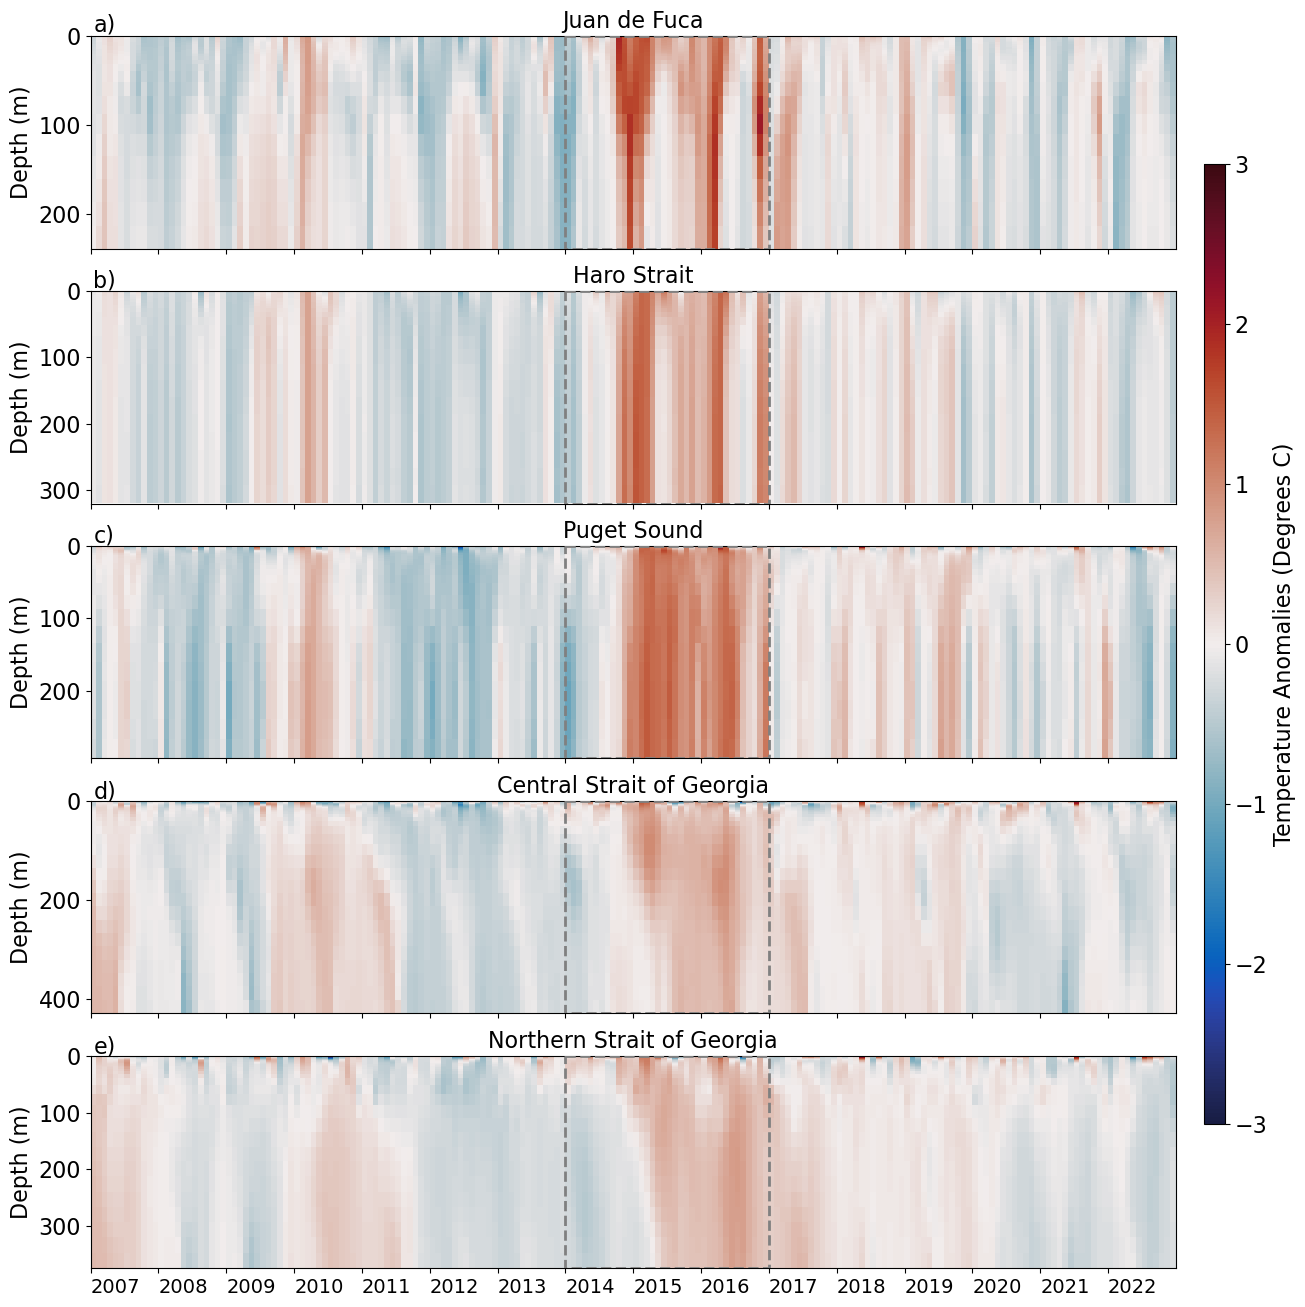

In [81]:
fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

variables = [(JdF_votemper_mean-JdFclim_temp), (Haro_votemper_mean-Haroclim_temp), (Puget_votemper_mean-Pugetclim_temp), (CSOG_votemper_mean-CSOGclim_temp), (NSOG_votemper_mean-NSOGclim_temp)]
depths = [JdF_depth, Haro_depth, Puget_depth, CSOG_depth, NSOG_depth]

## set depth ranges

depth_ranges = [
    (0,239),
    (0,321),
    (0,294),
    (0,429),(0,375)]

titles = ['Juan de Fuca', 'Haro Strait', 'Puget Sound', 'Central Strait of Georgia', 'Northern Strait of Georgia']
labels = ['a)', 'b)', 'c)', 'd)', 'e)']
colorbars = []

for i, ax in enumerate(axes):
    cb = hovmoller(ax, variables[i], depths[i], tt,
                   depth_range=depth_ranges[i], date_range=date_range,
                   title=titles[i], var_title='Temperature Anomalies (Degrees C)',
                   vmin=-3, vmax=3, cmap=cmo.cm.balance);

    ax.set_ylabel('Depth (m)')
    if i < len(axes) - 1:
        ax.set_xlabel('')  # Remove x-labels for all but last plot
    ax.text(tt[0], depth_ranges[i][0] - 5, labels[i])  # Label just above surface
    if cb is not None:
        colorbars.append(cb)

    # Highlight NEP-MHW period (use a box here instead of shading)
    # Define the corners of the box
    a = dt.datetime(2014, 1, 1)  # Start of box
    b = dt.datetime(2016, 12, 31)  # End of box

    # Make sure your y-limits match the actual depth range
    ymin, ymax = depth_ranges[i][0], depth_ranges[i][1]

    # Add rectangle
    rect = patches.Rectangle(
        (mdates.date2num(a), ymin),  # Convert datetime to Matplotlib float format
        mdates.date2num(b) - mdates.date2num(a),  # Width
        ymax - ymin,  # Height
        linewidth=2,
        linestyle='--',
        edgecolor='grey',
        facecolor='none',
        zorder=10  # Ensure it draws on top
    )
    ax.add_patch(rect)

        
# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
fig.colorbar(colorbars[0], cax=cbar_ax, label='Temperature Anomalies (Degrees C)', ticks=np.arange(-3, 4, 1))
ax.set_xlabel('')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set major ticks to be at the start of each year and format as 'YYYY'
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Optional: rotate tick labels and adjust layout
plt.setp(axes[-1].get_xticklabels(), rotation=0, ha='left',fontsize=14)

plt.show();


In [82]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    e3t_JdF = np.copy(mesh.variables['e3t_0'][0,:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
    e3t_JdF_mean=np.tile(np.mean(e3t_JdF, axis=(1, 2)),(192, 1)).T
    
    gdept_JdF = np.copy(mesh.variables['gdept_0'][0,:,JdF[0]:JdF[1], 
                               JdF[2]:JdF[3]])
    
    gdept_JdF_mean=(np.mean(gdept_JdF, axis=(1, 2))).T
    
    
    
    e3t_Haro = np.copy(mesh.variables['e3t_0'][0,:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]])
    e3t_Haro_mean=np.tile(np.mean(e3t_Haro, axis=(1, 2)),(192, 1)).T
    
    gdept_Haro = np.copy(mesh.variables['gdept_0'][0,:,Haro[0]:Haro[1], 
                               Haro[2]:Haro[3]])
    
    gdept_Haro_mean=(np.mean(gdept_Haro, axis=(1, 2))).T
    
    
    e3t_Puget = np.copy(mesh.variables['e3t_0'][0,:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]])
    e3t_Puget_mean=np.tile(np.mean(e3t_Puget, axis=(1, 2)),(192, 1)).T
    
    gdept_Puget = np.copy(mesh.variables['gdept_0'][0,:,Puget[0]:Puget[1], 
                               Puget[2]:Puget[3]])
    
    gdept_Puget_mean=(np.mean(gdept_Puget, axis=(1, 2))).T
    
    
    e3t_CSOG = np.copy(mesh.variables['e3t_0'][0,:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
    e3t_CSOG_mean=np.tile(np.mean(e3t_CSOG, axis=(1, 2)),(192, 1)).T
    
    gdept_CSOG = np.copy(mesh.variables['gdept_0'][0,:,CentralSoG[0]:CentralSoG[1], 
                               CentralSoG[2]:CentralSoG[3]])
    
    gdept_CSOG_mean=(np.mean(gdept_CSOG, axis=(1, 2))).T
    
    
    e3t_NSOG = np.copy(mesh.variables['e3t_0'][0,:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]])
    e3t_NSOG_mean=np.tile(np.mean(e3t_NSOG, axis=(1, 2)),(192, 1)).T
    
    gdept_NSOG = np.copy(mesh.variables['gdept_0'][0,:,NorthernSoG[0]:NorthernSoG[1], 
                               NorthernSoG[2]:NorthernSoG[3]])
    
    gdept_NSOG_mean=(np.mean(gdept_NSOG, axis=(1, 2))).T
    
    #gdept_0 = mesh.variables['gdept_0'][0, :]  # shape: [depth]

In [83]:
np.shape(e3t_JdF_mean)

(40, 192)

In [84]:
np.shape(JdF_votemper_mean)

(40, 192)

In [85]:
np.shape(gdept_JdF_mean)

(40,)

In [86]:
def surface_anomaly(votemper_mean, clim_temp, thickness, depth_slice=slice(0, 24)):
    """
    Compute thickness-weighted mean temperature anomaly over specified depth range.
    
    Parameters:
        votemper_mean : ndarray [depth, y, x]
            Model temperature mean
        clim_temp : ndarray [depth, y, x]
            Climatological temperature
        thickness : ndarray [depth, y, x]
            Layer thickness (e3t)
        depth_slice : slice
            Depth levels to include (default: 0–23)
    
    Returns:
        anomaly_surf : ndarray [y, x]
            Thickness-weighted mean temperature anomaly at surface
    """
    # Slice input arrays
    anomaly = votemper_mean[depth_slice, :] - clim_temp[depth_slice, :]
    thick = thickness[depth_slice, :]

    # Create a mask for valid ocean cells (non-zero thickness)
    valid_mask = (thick > 0) & (~np.isnan(anomaly)) & (~np.isnan(thick))

    # Apply mask
    anomaly_masked = np.where(valid_mask, anomaly, np.nan)
    thick_masked   = np.where(valid_mask, thick, np.nan)

    # Compute weighted mean
    weighted_sum = np.nansum(anomaly_masked * thick_masked, axis=0)
    thickness_sum = np.nansum(thick_masked, axis=0)

    # Avoid division by zero
    anomaly_surf = np.where(thickness_sum != 0, weighted_sum / thickness_sum, np.nan)
    return anomaly_surf

In [87]:
print(np.shape(JdF_votemper_mean))
print(np.shape(JdFclim_temp))
print(np.shape(e3t_JdF_mean))

(40, 192)
(40, 192)
(40, 192)


In [88]:
### 0-50 m
JdF_anomalies_surf = surface_anomaly(JdF_votemper_mean, JdFclim_temp, e3t_JdF_mean)
Haro_anomalies_surf = surface_anomaly(Haro_votemper_mean, Haroclim_temp, e3t_Haro_mean)
Puget_anomalies_surf = surface_anomaly(Puget_votemper_mean, Pugetclim_temp, e3t_Puget_mean)
CSOG_anomalies_surf = surface_anomaly(CSOG_votemper_mean, CSOGclim_temp, e3t_CSOG_mean)
NSOG_anomalies_surf = surface_anomaly(NSOG_votemper_mean, NSOGclim_temp, e3t_NSOG_mean)

In [89]:
def mid_anomaly(votemper_mean, clim_temp, thickness, depth_slice=slice(23, 29)):
    """
    Compute thickness-weighted mean temperature anomaly over a depth range,
    excluding land or invalid cells based on layer thickness.
    
    Parameters:
        votemper_mean : ndarray [depth, y, x]
        clim_temp     : ndarray [depth, y, x]
        thickness     : ndarray [depth, y, x]
        depth_slice   : slice (default: 23–29)
    
    Returns:
        anomaly_mid : ndarray [y, x]
    """
    # Slice input arrays
    anomaly = votemper_mean[depth_slice, :] - clim_temp[depth_slice, :]
    thick = thickness[depth_slice, :]

    # Create a mask for valid ocean cells (non-zero thickness)
    valid_mask = (thick > 0) & (~np.isnan(anomaly)) & (~np.isnan(thick))

    # Apply mask
    anomaly_masked = np.where(valid_mask, anomaly, np.nan)
    thick_masked   = np.where(valid_mask, thick, np.nan)

    # Compute weighted mean
    weighted_sum = np.nansum(anomaly_masked * thick_masked, axis=0)
    thickness_sum = np.nansum(thick_masked, axis=0)

    # Final anomaly: avoid divide-by-zero
    anomaly_mid = np.where(thickness_sum != 0, weighted_sum / thickness_sum, np.nan)
    return anomaly_mid

In [90]:
### 50-150 m 
JdF_anomalies_mid = mid_anomaly(JdF_votemper_mean, JdFclim_temp, e3t_JdF_mean)
Haro_anomalies_mid = mid_anomaly(Haro_votemper_mean, Haroclim_temp, e3t_Haro_mean)
Puget_anomalies_mid = mid_anomaly(Puget_votemper_mean, Pugetclim_temp, e3t_Puget_mean)
CSOG_anomalies_mid = mid_anomaly(CSOG_votemper_mean, CSOGclim_temp, e3t_CSOG_mean)
NSOG_anomalies_mid = mid_anomaly(NSOG_votemper_mean, NSOGclim_temp, e3t_NSOG_mean)

In [91]:
def deep_anomaly(votemper_mean, clim_temp, thickness, depths, depth_min=150):
    """
    Compute thickness-weighted temperature anomaly from a minimum depth to bottom,
    masking land and below-bottom layers.

    Parameters:
        votemper_mean : ndarray [depth, y, x]
            Model temperature mean
        clim_temp : ndarray [depth, y, x]
            Climatological temperature
        thickness : ndarray [depth, y, x]
            Layer thickness (e3t)
        depths : ndarray [depth]
            Depth midpoint of each vertical level
        depth_min : float
            Minimum depth to start averaging from (default: 150m)

    Returns:
        anomaly_deep : ndarray [y, x]
            Thickness-weighted mean anomaly from 150m to bottom
    """
    # Identify depths >= 150 m
    level_mask = depths >= depth_min  # shape: [depth]
    
    # Subset the arrays
    votemp_deep = votemper_mean[level_mask, :]
    clim_deep = clim_temp[level_mask, :]
    thick_deep = thickness[level_mask, :]

    # Create land/bottom mask: where thickness is 0 or votemper is NaN
    valid_mask = (thick_deep > 0) & (~np.isnan(votemp_deep)) & (~np.isnan(clim_deep))

    # Apply the mask
    anomaly = np.where(valid_mask, votemp_deep - clim_deep, np.nan)
    thick_masked = np.where(valid_mask, thick_deep, np.nan)

    # Calculate the weighted mean
    weighted_sum = np.nansum(anomaly * thick_masked, axis=0)
    thickness_sum = np.nansum(thick_masked, axis=0)

    # Avoid division by zero
    anomaly_deep = np.where(thickness_sum != 0, weighted_sum / thickness_sum, np.nan)
    return anomaly_deep

In [92]:
print(np.shape(JdF_votemper_mean))
print(np.shape(JdFclim_temp))
print(np.shape(e3t_JdF_mean))
print(np.shape(gdept_JdF_mean))

(40, 192)
(40, 192)
(40, 192)
(40,)


In [93]:
### 150 m to bottom 
JdF_anomalies_deep = deep_anomaly(JdF_votemper_mean, JdFclim_temp, e3t_JdF_mean,gdept_JdF_mean)
Haro_anomalies_deep = deep_anomaly(Haro_votemper_mean, Haroclim_temp, e3t_Haro_mean,gdept_Haro_mean)
Puget_anomalies_deep = deep_anomaly(Puget_votemper_mean, Pugetclim_temp, e3t_Puget_mean,gdept_Puget_mean)
CSOG_anomalies_deep = deep_anomaly(CSOG_votemper_mean, CSOGclim_temp, e3t_CSOG_mean,gdept_CSOG_mean)
NSOG_anomalies_deep = deep_anomaly(NSOG_votemper_mean, NSOGclim_temp, e3t_NSOG_mean,gdept_NSOG_mean)

### Plot 0-50m Temperature Anomalies

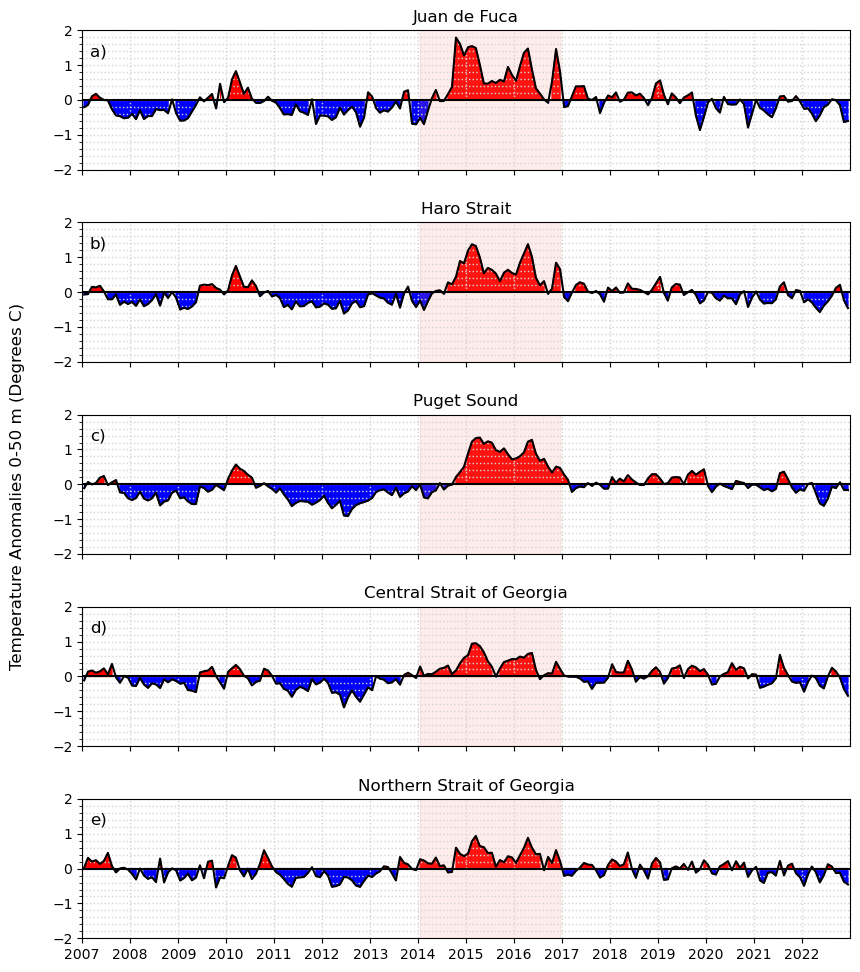

In [94]:
fig, axes = plt.subplots(5, 1, figsize=(9, 10), sharex=True)

x = tt  
mean_anomalies_surf_list = [JdF_anomalies_surf,
                            Haro_anomalies_surf,
                            Puget_anomalies_surf,
                            CSOG_anomalies_surf,
                            NSOG_anomalies_surf]  
titles = [
    'Juan de Fuca', 'Haro Strait', 'Puget Sound',
    'Central Strait of Georgia', 'Northern Strait of Georgia'
]

labels = ['a)', 'b)', 'c)', 'd)', 'e)']

for i, ax in enumerate(axes):
    y = mean_anomalies_surf_list[i]
    
    ax.plot(x, y, color='k')
    ax.set_ylim(-2, 2)
    
    ax.minorticks_on()
    ax.grid(which='major', linestyle=':', linewidth=1, color='lightgrey')
    ax.grid(which='minor', linestyle=':', linewidth=1, color='lightgrey')
    
    
    
    hloc = YearLocator(1)
    ax.xaxis.set_minor_locator(hloc)
    
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=10)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelsize=10)
    

    ax.axhline(y=0, color='k', linestyle='-')
    ax.fill_between(x, y, where=(y < 0), color='blue')
    ax.fill_between(x, y, where=(y > 0), color='red')

    ax.set_title(titles[i], fontsize=12)

    ax.text(0.01, 0.9, labels[i], transform=ax.transAxes,
            fontsize=12, va='top')
    
    # Highlight NEP-MHW period
    a = tt[84]
    b = tt[119]
    ax.fill([a, a, b, b], [-10, 10, 10, -10], color='salmon', alpha=0.15)

    # Limit x-axis to 2007–2022
    ax.set_xlim(np.datetime64('2007-01-01'), np.datetime64('2022-12-31'))
    
# Only the bottom plot gets the x-axis ticks
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.setp(axes[-1].get_xticklabels(), rotation=0, ha='left', fontsize=12)
plt.setp(axes[-1].get_xticklabels(), fontsize=10, rotation=0, ha='center')

# Shared y-axis label on the left side
fig.text(0.04, 0.5, 'Temperature Anomalies 0-50 m (Degrees C)', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 1])  # leave room on left for y-label
plt.show()

### Plot 50-150 m Temperature Anomalies

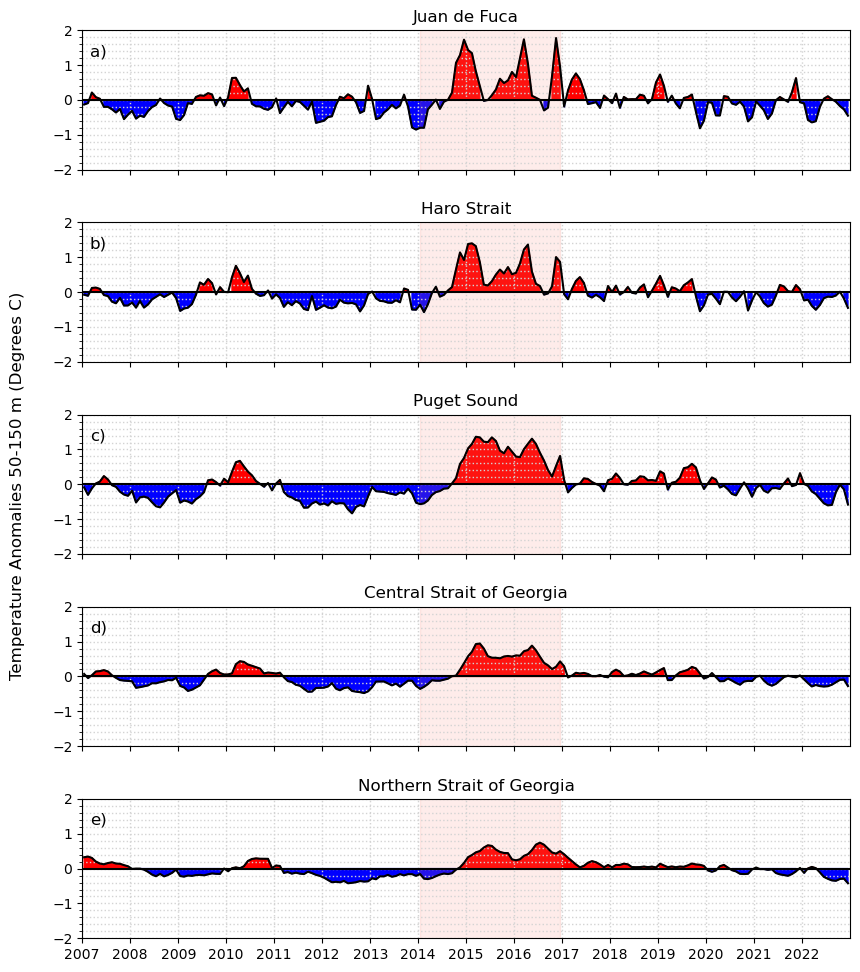

In [95]:
fig, axes = plt.subplots(5, 1, figsize=(9, 10), sharex=True)

x = tt  
mean_anomalies_surf_list = [JdF_anomalies_mid,
                            Haro_anomalies_mid,
                            Puget_anomalies_mid,
                            CSOG_anomalies_mid,
                            NSOG_anomalies_mid]  
titles = [
    'Juan de Fuca', 'Haro Strait', 'Puget Sound',
    'Central Strait of Georgia', 'Northern Strait of Georgia'
]

labels = ['a)', 'b)', 'c)', 'd)', 'e)']

for i, ax in enumerate(axes):
    y = mean_anomalies_surf_list[i]
    
    ax.plot(x, y, color='k')
    ax.set_ylim(-2, 2)
    
    ax.minorticks_on()
    ax.grid(which='major', linestyle=':', linewidth=1, color='lightgrey')
    ax.grid(which='minor', linestyle=':', linewidth=1, color='lightgrey')
    
    
    
    hloc = YearLocator(1)
    ax.xaxis.set_minor_locator(hloc)
    
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=10)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelsize=10)
    

    ax.axhline(y=0, color='k', linestyle='-')
    ax.fill_between(x, y, where=(y < 0), color='blue')
    ax.fill_between(x, y, where=(y > 0), color='red')

    ax.set_title(titles[i], fontsize=12)

    ax.text(0.01, 0.9, labels[i], transform=ax.transAxes,
            fontsize=12, va='top')
    
    # Highlight NEP-MHW period
    a = tt[84]
    b = tt[119]
    ax.fill([a, a, b, b], [-10, 10, 10, -10], color='salmon', alpha=0.15)

    # Limit x-axis to 2007–2022
    ax.set_xlim(np.datetime64('2007-01-01'), np.datetime64('2022-12-31'))
    
# Only the bottom plot gets the x-axis ticks
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.setp(axes[-1].get_xticklabels(), rotation=0, ha='left', fontsize=12)
plt.setp(axes[-1].get_xticklabels(), fontsize=10, rotation=0, ha='center')

# Shared y-axis label on the left side
fig.text(0.04, 0.5, 'Temperature Anomalies 50-150 m (Degrees C)', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 1])  # leave room on left for y-label
plt.show()

### Plot 150 m to bottom Temperature Anomalies

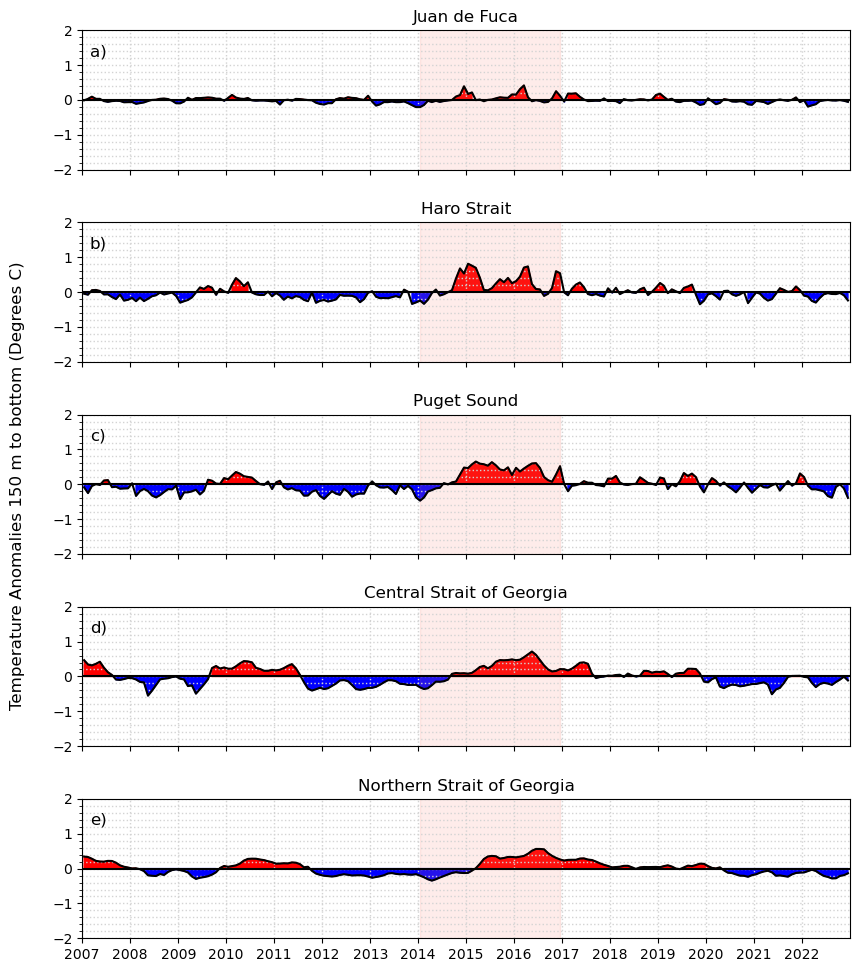

In [96]:
fig, axes = plt.subplots(5, 1, figsize=(9, 10), sharex=True)

x = tt  
mean_anomalies_surf_list = [JdF_anomalies_deep,
                            Haro_anomalies_deep,
                            Puget_anomalies_deep,
                            CSOG_anomalies_deep,
                            NSOG_anomalies_deep]  
titles = [
    'Juan de Fuca', 'Haro Strait', 'Puget Sound',
    'Central Strait of Georgia', 'Northern Strait of Georgia'
]

labels = ['a)', 'b)', 'c)', 'd)', 'e)']

for i, ax in enumerate(axes):
    y = mean_anomalies_surf_list[i]
    
    ax.plot(x, y, color='k')
    ax.set_ylim(-2, 2)
    
    ax.minorticks_on()
    ax.grid(which='major', linestyle=':', linewidth=1, color='lightgrey')
    ax.grid(which='minor', linestyle=':', linewidth=1, color='lightgrey')
    
    
    
    hloc = YearLocator(1)
    ax.xaxis.set_minor_locator(hloc)
    
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelsize=10)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelsize=10)
    

    ax.axhline(y=0, color='k', linestyle='-')
    ax.fill_between(x, y, where=(y < 0), color='blue')
    ax.fill_between(x, y, where=(y > 0), color='red')

    ax.set_title(titles[i], fontsize=12)

    ax.text(0.01, 0.9, labels[i], transform=ax.transAxes,
            fontsize=12, va='top')
    
    # Highlight NEP-MHW period
    a = tt[84]
    b = tt[119]
    ax.fill([a, a, b, b], [-10, 10, 10, -10], color='salmon', alpha=0.15)

    # Limit x-axis to 2007–2022
    ax.set_xlim(np.datetime64('2007-01-01'), np.datetime64('2022-12-31'))
    
# Only the bottom plot gets the x-axis ticks
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.setp(axes[-1].get_xticklabels(), rotation=0, ha='left', fontsize=12)
plt.setp(axes[-1].get_xticklabels(), fontsize=10, rotation=0, ha='center')

# Shared y-axis label on the left side
fig.text(0.04, 0.5, 'Temperature Anomalies 150 m to bottom (Degrees C)', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 1])  # leave room on left for y-label
plt.show()

In [97]:
JdFfiles.close()
Harofiles.close()
Pugetfiles.close()
CSOGfiles.close()
NSOGfiles.close()

In [98]:
# Use this cell to calculate maximum temp anomalies for different time periods or regions
mask = (tt >= np.datetime64('2015-01-01')) & (tt <= np.datetime64('2015-12-31'))

# Apply the mask to get anomalies in that date range
anomaly_window = CSOG_anomalies_surf[mask]

# Find the maximum anomaly value in that window
max_anomaly = np.nanmax(anomaly_window)

print(f'Maximum temperature anomaly (2009–2010): {max_anomaly:.2f} °C')

Maximum temperature anomaly (2009–2010): 0.95 °C


In [99]:
# Use this cell to calculate maximum temp anomalies for different time periods or regions
mask = (tt >= np.datetime64('2007-01-01')) & (tt <= np.datetime64('2022-12-31'))

# Apply the mask to get anomalies in that date range
anomaly_window = CSOG_anomalies_surf[mask]

# Find the maximum anomaly value in that window
max_anomaly = np.nanmax(anomaly_window)

print(f'Maximum temperature anomaly (2009–2010): {max_anomaly:.2f} °C')

Maximum temperature anomaly (2009–2010): 0.95 °C


## Add climate indices for statistical relationships

In [100]:
Monthly_SOI=np.array([-7.8,-2.7,-1.4,-3,-2.7,5,-5,0.7,1.4,5.4,9.2,14.4, #2007
14.1,21.3,12.2,4.5,-3.5,4.2,2.2,9.1,13.5,13.4,17.1,13.3, #2008
9.4,14.8,0.2,8.6,-7.4,-2.3,1.6,-5,3.9,-14.7,-6,-7, #2009
-10.1,-14.5,-10.6,15.2,10,1.8,20.5,18.8,24.9,18.3,16.4,27.1, #2010
19.9,22.3,21.4,25.1,2.1,0.2,10.7,2.1,11.7,7.3,13.8,23, #2011
9.4,2.5,2.9,-7.1,-2.7,-10.4,-1.7,-5,2.6,2.4,3.9,-6, #2012
-1.1,-3.6,10.5,0.3,8.4,13.9,8.1,-0.5,3.9,-1.9,9.2,0.6, #2013
12.2,-1.3,-13.3,8.6,4.4,-1.5,-3,-11.4,-7.6,-8,-10,-5.5, #2014
-7.8,0.6,-11.2,-3.8,-13.7,-12,-14.7,-19.8,-17.8,-20.2,-5.3,-9.1, #2015
-19.7,-19.7,-4.7,-22,2.8,5.8,4.2,5.3,13.5,-4.3,-0.7,2.6, #2016
1.3,-2.2,5.1,-9.3,0.5,-10.4,8.1,3.3,6.9,9.1,11.8,-1.4, #2017                    
8.9,-6,10.5,4.5,2.1,-5.5,1.6,-6.9,-10,3,-0.1,9.3, #2018
                     -0.6,-13.5,-6.8,-1.3,-9,-10.4,-5.6,-4.4,-12.4,-5.6,-9.3,-5.5, #2019
                     1.3,-2.2,-5.2,-0.5,2.8,-9.6,4.2,9.8,10.5,4.2,9.2,16.9, #2020
                     16.5,11.5,-0.3,2,3.6,2.6,15.9,4.6,9.3,6.7,12.5,13.8, #2021
                     4.1,8.2,13.8,22.6,17.1,21.2,8.7,9.1,18.3,17.7,4.6,20 #2022
                     ])

In [101]:
Monthly_NPGO=np.array([-0.24,-0.73,-0.18,0.38,0.14,1.23,1.23,1.43,0.11,1.27,0.14,0.22, #2007
                      0.18,1.14,1.37,1.40,1.74,1.28,1.43,2.14,2.23,1.77,1.97,0.23, #2008
                      0.14,0.11,0.30,0.24,0.18,0.27,0.18,0.14,0.10,1.15,1.05,1.06, #2009
                      2.06,1.84,1.65,1.18,1.87,1.24,1.15,1.08,1.00,1.61,0.10,0.13, #2010
                      0.31,0.18,1.20,0.17,1.39,1.11,1.04,1.04,1.33,1.20,0.27,0.76, #2011
                      0.12,0.12,1.12,1.93,1.63,1.94,1.86,1.73,1.36,1.87,1.40,1.20, #2012
                      1.23,1.20,0.16,0.21,0.12,0.14,0.22,0.20,0.26,-0.68,-0.12,-1.45, #2013
                      -0.26,-0.37,-0.22,-0.16,0.44,-0.24,-0.75,-0.18,-0.13,0.24,0.32,-0.28, #2014
                      -0.18,-1.27,-1.40,-1.38,-0.14,-1.25,-1.47,-1.93,-2.10,-1.31,-2.25,-1.11, #2015
                      0.11,0.44,0.21,-0.25,-0.15,-0.10,-0.21,-0.18,-0.13,0.28,1.16,-1.54, #2016
                      1.62,-0.15,-0.11,-0.88,-0.22,-0.34,-0.23,-0.19,-0.19,-1.41,-2.06,-2.69, #2017
                      -1.50,-2.23,-2.03,-2.06,-1.92,-1.94,-1.57,-2.12,-2.32,-2.34,-1.77,-1.02, #2018
                     -0.12,-2.56,-1.99,-2.16,-1.86,-2.35,-2.16,-2.06,-2.52,-2.58,-3.37,-2.54, #2019
                     -1.52,-2.32,-1.83,-1.88,-1.36,-1.89,-2.04,-1.36,1.25,-1.83,-2.59,-1.33, #2020
                     -0.58,-1.20,-0.86,-1.89,-0.86,-0.55,-0.69,-0.96,-0.67,-0.06,-0.30,-1.99, #2021
                     -1.35,-1.85,-1.22,-0.67,-0.29,-0.52,-0.32,-0.39,-0.67,0.00,0.00,0.00, #2022
                      ])

In [102]:
from scipy import stats

### Juan de Fuca Stats

In [103]:
JdFsurf_NPGO=stats.pearsonr(Monthly_NPGO, JdF_anomalies_surf)
print(JdFsurf_NPGO)

PearsonRResult(statistic=-0.1129191767883437, pvalue=0.11889498005407016)


In [104]:
JdFsurf_SOI=stats.pearsonr(Monthly_SOI, JdF_anomalies_surf)
print(JdFsurf_SOI)

PearsonRResult(statistic=-0.44318980780573997, pvalue=1.2147889646213271e-10)


In [105]:
JdFmid_NPGO=stats.pearsonr(Monthly_NPGO, JdF_anomalies_mid)
print(JdFmid_NPGO)

PearsonRResult(statistic=-0.009391625604444884, pvalue=0.8971303557078283)


In [106]:
JdFmid_SOI=stats.pearsonr(Monthly_SOI, JdF_anomalies_mid)
print(JdFmid_SOI)

PearsonRResult(statistic=-0.43214779033606787, pvalue=3.8744366604332844e-10)


In [107]:
JdFdeep_NPGO=stats.pearsonr(Monthly_NPGO, JdF_anomalies_deep)
print(JdFdeep_NPGO)

PearsonRResult(statistic=0.14218320943956334, pvalue=0.049149831931512206)


In [108]:
JdFdeep_SOI=stats.pearsonr(Monthly_SOI, JdF_anomalies_deep)
print(JdFdeep_SOI)

PearsonRResult(statistic=-0.3844538363315922, pvalue=3.682742484639512e-08)


### Central SoG Stats

In [109]:
CSOGsurf_NPGO=stats.pearsonr(Monthly_NPGO, CSOG_anomalies_surf)
print(CSOGsurf_NPGO)

PearsonRResult(statistic=-0.35857264820291845, pvalue=3.2742973914124573e-07)


In [110]:
CSOGsurf_SOI=stats.pearsonr(Monthly_SOI, CSOG_anomalies_surf)
print(CSOGsurf_SOI)

PearsonRResult(statistic=-0.3253981776161845, pvalue=4.117435497599967e-06)


In [111]:
CSOGmid_NPGO=stats.pearsonr(Monthly_NPGO, CSOG_anomalies_mid)
print(CSOGmid_NPGO)

PearsonRResult(statistic=-0.2595743792912586, pvalue=0.0002771175332586996)


In [112]:
CSOGmid_SOI=stats.pearsonr(Monthly_SOI, CSOG_anomalies_mid)
print(CSOGmid_SOI)

PearsonRResult(statistic=-0.37938375261212537, pvalue=5.736467363831411e-08)


In [113]:
CSOGdeep_NPGO=stats.pearsonr(Monthly_NPGO, CSOG_anomalies_deep)
print(CSOGdeep_NPGO)

PearsonRResult(statistic=-0.0798100445737198, pvalue=0.2711511941718949)


In [114]:
CSOGdeep_SOI=stats.pearsonr(Monthly_SOI, CSOG_anomalies_deep)
print(CSOGdeep_SOI)

PearsonRResult(statistic=-0.28133519838534615, pvalue=7.718402010380919e-05)


ValueError: too many values to unpack (expected 2)

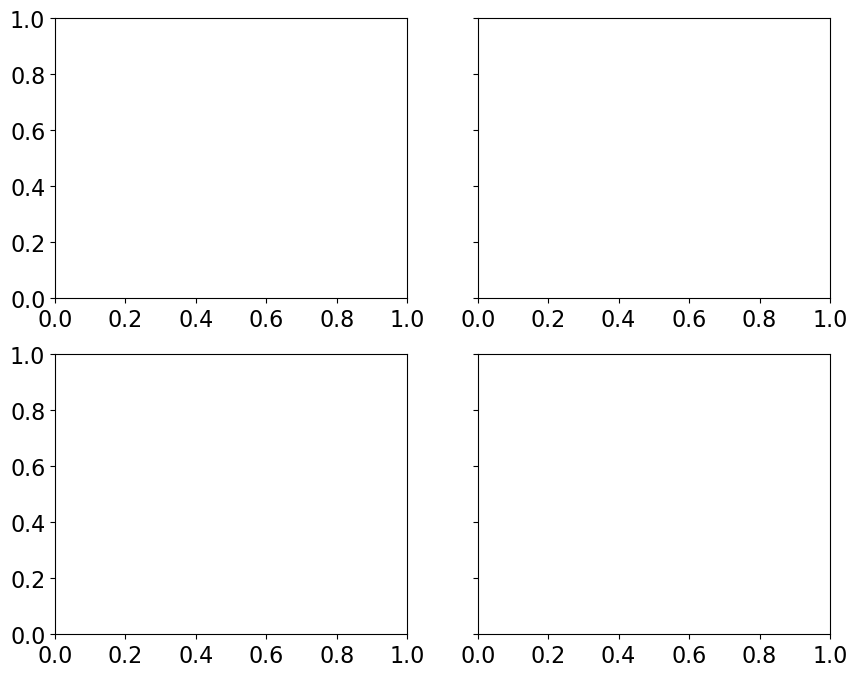

In [116]:
# --- Your data arrays ---
# Monthly_NPGO, Monthly_SOI
# CSOG_anomalies_surf, JdF_anomalies_surf
# surfmaskCSOG, surfmaskJdF

# Define regions and indices
regions = {
    "Juan de Fuca": (JdF_anomalies_surf),
    "Central Strait of Georgia": (CSOG_anomalies_surf)
}

indices = {
    "NPGO": Monthly_NPGO,
    "SOI": Monthly_SOI
}

# Create 2×2 figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=True)

# Set all font sizes to 12 pt
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

for i, (index_name, index_array) in enumerate(indices.items()):   # Rows: NPGO (top), SOI (bottom)
    for j, (region_name, (temp_array, region_mask)) in enumerate(regions.items()):  # Cols: JdF (left), CSOG (right)
        ax = axes[i, j]

        # Subset data
        x = index_array[region_mask]
        y = temp_array[region_mask]
        valid = ~np.isnan(x) & ~np.isnan(y)
        x = x[valid]
        y = y[valid]
        if len(x) < 3:
            continue

        # Scatter points
        sns.scatterplot(x=x, y=y, ax=ax, color='steelblue', s=60, alpha=0.8)

        # Regression
        slope, intercept, r, p, stderr = linregress(x, y)
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = intercept + slope * x_vals
        line_style = '-' if p < 0.05 else '--'
        ax.plot(x_vals, y_vals, color='k', lw=2, ls=line_style)

        # Annotate r and p in bottom right
        ax.text(0.95, 0.05, f"r={r:.2f}, p={p:.3f}",
            transform=ax.transAxes, fontsize=12, color='k',
            ha='right', va='bottom')
    

        # Titles & labels
        ax.set_title(f"{region_name}")
        ax.set_xlabel(index_name)
        if j == 0:
            ax.set_ylabel("Temperature Anomalies 0-50 m (Degrees C)")
        else:
            ax.set_ylabel("")

# Adjust layout
plt.tight_layout(pad=2.0)
plt.show()

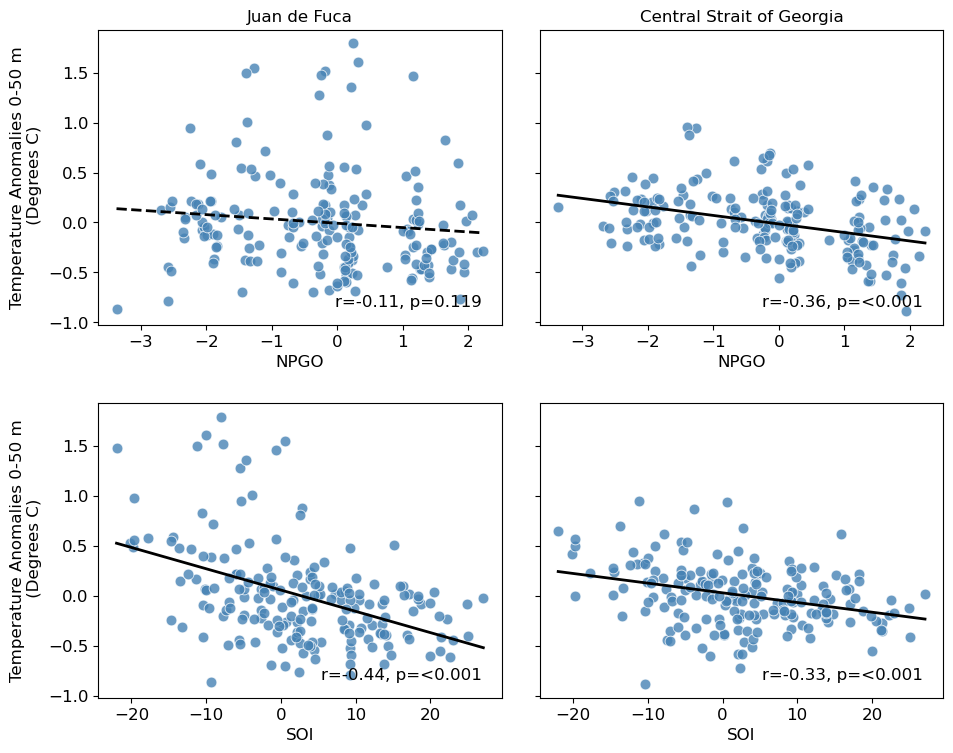

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

# --- Your data arrays ---
# Monthly_NPGO, Monthly_SOI
# CSOG_anomalies_surf, JdF_anomalies_surf

# Define regions and indices (no masks)
regions = {
    "Juan de Fuca": JdF_anomalies_surf,
    "Central Strait of Georgia": CSOG_anomalies_surf
}

indices = {
    "NPGO": Monthly_NPGO,
    "SOI": Monthly_SOI
}

# Create 2×2 figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=True)

# Set font sizes
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

for i, (index_name, index_array) in enumerate(indices.items()):   # Rows: NPGO (top), SOI (bottom)
    for j, (region_name, temp_array) in enumerate(regions.items()):  # Columns: JdF (left), CSOG (right)
        ax = axes[i, j]

        # Drop NaNs
        valid = ~np.isnan(index_array) & ~np.isnan(temp_array)
        x = index_array[valid]
        y = temp_array[valid]
        if len(x) < 3:
            continue

        # Scatter
        sns.scatterplot(x=x, y=y, ax=ax, color='steelblue', s=60, alpha=0.8)

        # Linear regression
        slope, intercept, r, p, stderr = linregress(x, y)
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = intercept + slope * x_vals
        line_style = '-' if p < 0.05 else '--'
        ax.plot(x_vals, y_vals, color='k', lw=2, ls=line_style)

        # Annotate r and p in bottom right with thresholds
        if p < 0.001:
            p_text = "<0.001"
        elif p < 0.01:
            p_text = "<0.01"
        elif p < 0.05:
            p_text = "<0.05"
        else:
            p_text = f"{p:.3f}"  # show actual p-value if not significant

        ax.text(0.95, 0.05, f"r={r:.2f}, p={p_text}",
                transform=ax.transAxes, fontsize=12, color='k',
                ha='right', va='bottom')
        
        # Titles & labels
        if i == 0:  # only show region name at the top row
            ax.set_title(f"{region_name}")
        else:
            ax.set_title("")

        ax.set_xlabel(index_name)
        if j == 0:
            ax.set_ylabel("Temperature Anomalies 0-50 m\n (Degrees C)")
        else:
            ax.set_ylabel("")

# Adjust layout
plt.tight_layout(pad=2.0)
plt.show()
